In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    default_data_collator,
)

In [2]:
import lang2vec as l2v

In [3]:
from pathlib import Path
import functools as ft
import torch

In [4]:
import evaluate
import pandas as pd
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

In [5]:
import pandas as pd
import re

In [6]:
from rich.pretty import pprint

Misc functions:

In [7]:
def cuda_report():
    avail = torch.cuda.is_available()
    ngpu = torch.cuda.device_count()
    print(f"GPUs available? {avail}")
    print(f"Number of GPUs: {ngpu}")

In [8]:
def invert_dict(d):
    return {v: k for k,v in d.items()}

Human readable languages

In [9]:
LANGUAGES_PATH = "../data/ntrex/LANGUAGES_tab.tsv"

In [10]:
lang_to_human_readable_language = pd.read_csv(
    LANGUAGES_PATH, sep="\t", 
    header=None, names=["language_code", "language"]
).set_index('language_code').language.to_dict()

temporary = {}
for lang, long_lang in lang_to_human_readable_language.items():
    lang_no_orth = lang.split("-")[0]
    long_lang_no_orth = re.sub(pattern="\(.*\)", repl="", string=long_lang).strip()
    if lang_no_orth not in lang_to_human_readable_language:
        temporary[lang_no_orth] = long_lang_no_orth
        
lang_to_human_readable_language.update(temporary)

In [11]:
def human_readify_lang_code(lang_code: str):
    language = lang_to_human_readable_language.get(lang_code, "UNKNOWN")
    return f"{language} ({lang_code})"

### Loading the data without preprocessing a la `click_finetune_xlmr.py`

In [12]:
FLORES_PATH = "../data-bin/flores-dev-no-orth/"
NTREX_PATH = "../data-bin/ntrex-no-orth/"
FLORES_WITH_ORTH_PATH = "../data/flores200/dev/"

MODEL_NAME = "xlm-roberta-base"
LABEL_COLUMN = "language"
TEXT_COLUMN = "text"

MAX_LENGTH_TOKENS=128

In [13]:
import datasets as ds

We can first break the data loading from `click_finetune_xlmr.py` to separate small functions:

First, we need something for loading the raw FLORES/NTREX data from disk:

In [14]:
def load_flores_ntrex(
    flores_path,
    ntrex_path
):
    flores = ds.load_from_disk(flores_path)
    ntrex = ds.load_from_disk(ntrex_path)

    # Create language -> integer id mapping
    all_langs_in_common = {lang for lang in flores} & {lang for lang in ntrex}
    language_to_id = {language: i for i, language in enumerate(all_langs_in_common)}
    id_to_language = {i: language for language, i in language_to_id.items()}
    
    return flores, ntrex, language_to_id, id_to_language

In [15]:
flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(FLORES_PATH, NTREX_PATH)

In [16]:
FINETUNE_LANGS = ["fin", "eng"]
TEST_LANGS = ["fin", "eng"]

Second, we'll want functionality to only keep a subset of languages in each dataset: 

In [17]:
def stack_finetune_and_test_data(ntrex, flores, finetune_langs, test_langs):
    
    if not finetune_langs:
        finetune_langs = [lang for lang in ntrex]
    elif finetune_langs == "flores":
        finetune_langs = [lang for lang in flores if lang in ntrex]
    
    if not test_langs:
        test_langs = [lang for lang in flores]
    
    # Define new dataset based on label column and finetuning langs
    data_for_finetune = ds.concatenate_datasets(
        [ntrex[lang] for lang in finetune_langs]
    )
    
    data_for_test = ds.concatenate_datasets([flores[lang] for lang in test_langs])
    
    return data_for_finetune, data_for_test

We also want to encapsulate renaming columns:

In [18]:
def rename_columns(dataset, col_from_to):
    for col_from, col_to in col_from_to:
        if col_to not in dataset.column_names:
            dataset = dataset.rename_column(col_from, col_to)
    return dataset

In [19]:
def _rename_text_and_label_col(dataset, text_column, label_column):
    rename_these = [(text_column, "text"), (label_column, "label")]
    return rename_columns(dataset, rename_these)

rename_text_and_label_col = ft.partial(_rename_text_and_label_col,
                                       text_column=TEXT_COLUMN, 
                                       label_column=LABEL_COLUMN)

With these changes, we have the following function for text classification.

Note that a lot of the "heavy lifting" happens using `intermediate_functions`.

In [20]:
def load_data_for_text_clf(
    flores_path,
    ntrex_path,
    model_name,
    label_column,
    text_column,
    finetune_langs,
    test_langs,
    max_length_tokens,
    intermediate_functions=None
):
    if intermediate_functions is None:
        intermediate_functions = []
        
    # STEP 1: LOAD RAW DATA & CREATE MAPPINGS
    flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(
        flores_path, ntrex_path
    )
    
    # STEP 2: STACK INTO data_for_finetune, data_for_test
    data_for_finetune, data_for_test = stack_finetune_and_test_data(
        ntrex, flores, finetune_langs, test_langs
    )
    
    # STEP 3: APPLY OPTIONAL INTERMEDIATE FUNCTIONS
    for func in intermediate_functions:
        try:
            print(f"Executing intermediate func: {func.__name__}")
        except:
            print(f"Executing intermediate func: {func.func.__name__}")
        data_for_finetune = func(data_for_finetune)
        data_for_test = func(data_for_test)

    return (
        data_for_finetune,
        data_for_test,
        flores,
        ntrex,
        language_to_id,
        id_to_language,
    )

In [21]:
_load_data_for_text_clf = ft.partial(load_data_for_text_clf,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
    model_name=MODEL_NAME,
    label_column=LABEL_COLUMN,
    text_column=TEXT_COLUMN,
    finetune_langs=FINETUNE_LANGS,
    test_langs=TEST_LANGS,
    max_length_tokens=MAX_LENGTH_TOKENS)

## Loading data for various tasks

### Language ID

In [22]:
data_for_finetune, data_for_test, flores, ntrex, language_to_id, id_to_language = \
_load_data_for_text_clf(
    intermediate_functions=[rename_text_and_label_col]
)

Executing intermediate func: _rename_text_and_label_col


In [23]:
data_for_finetune

Dataset({
    features: ['text', 'label'],
    num_rows: 3994
})

In [24]:
data_for_finetune[123]

{'text': 'Luonnononnettomuudet tekevät logistiikasta vielä monimutkaisempaa.',
 'label': 'fin'}

### Orthography ID

In [25]:
from collections import defaultdict

In [26]:
def get_lang_and_orthography(path: Path) -> str:
    return path.name.replace(".dev", "").split("_")

def get_flores_lang2orth(flores_dev_path: str = "../data/flores200/dev/") -> dict[str, str]:
    files = list(Path(flores_dev_path).glob("*.dev"))
    out = defaultdict(list)
    for p in files:
        lang, orth = get_lang_and_orthography(p)
        out[lang].append(orth)
    return out

def add_new_column(dataset: ds.Dataset, column_name: str, column_values: list):
    return dataset.add_column(column_name, column_values)

def _add_orthography_column(dataset, lang2orth_map, language_column="language"):
    orths = [lang2orth_map[lang][0] if lang in lang2orth_map else "unknown" for lang in dataset[language_column]]
    return add_new_column(dataset, column_name="orthography", column_values=orths)

In [27]:
flores_lang2orth = get_flores_lang2orth(FLORES_WITH_ORTH_PATH)

add_orthography_column = ft.partial(
    _add_orthography_column, 
    lang2orth_map=flores_lang2orth, 
    language_column="language"
)

rename_orth_to_label = ft.partial(_rename_text_and_label_col,
                                  text_column=TEXT_COLUMN, 
                                  label_column="orthography")

In [28]:
data_for_finetune, data_for_test, flores, ntrex, language_to_id, id_to_language = \
_load_data_for_text_clf(
    intermediate_functions=[add_orthography_column, rename_orth_to_label]
)

Executing intermediate func: _add_orthography_column
Executing intermediate func: _rename_text_and_label_col


In [29]:
data_for_finetune[123]

{'text': 'Luonnononnettomuudet tekevät logistiikasta vielä monimutkaisempaa.',
 'language': 'fin',
 'label': 'Latn'}

## Is this sentence pair related?

In [30]:
flores['fin'][0]

{'text': 'Stanfordin yliopiston lääketieteen laitoksen tutkijat ilmoittivat maanantaina uuden diagnostiikkatyökalun keksimisestä: solut tyypin mukaan lajitteleva pienenpieni tulostettava siru, joka voidaan valmistaa normaaleilla mustesuihkutulostimilla mahdollisesti noin yhden Yhdysvaltain sentin kappalehintaan.',
 'language': 'fin'}

In [31]:
flores['eng'][[0, 4]]

{'text': ['On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.',
  'Local media reports an airport fire vehicle rolled over while responding.'],
 'language': ['eng', 'eng']}

1. pick language pair
2. pick `n_pos` indices to represent positive pairs
3. pick `n_neg` indices to represent negative pairs

In [32]:
import numpy as np

In [33]:
SEED = 12345

In [34]:
np.random.seed(12345)

In [35]:
import random

In [36]:
import itertools as it

In [37]:
from rich.progress import track

In [38]:
def create_pairs_data(dataset, lang_pairs, n_pos, n_neg, num_rows):

    indices = [ix for ix in range(num_rows)]
    if n_pos > 0:
        positive_indices = np.random.randint(low=0, high=num_rows, size=n_pos)
    else:
        positive_indices = indices
    
    potential_negative_pairs = [
        (a, b) for a, b in it.combinations(indices, 2) if a != b
    ]
    
    if n_neg > 0:
        negative_indices = np.random.choice(
            range(len(potential_negative_pairs)), size=n_neg
        )
    else:
        negative_indices = range(len(potential_negative_pairs))
        
    negative_indices = [potential_negative_pairs[idx] for idx in negative_indices]
    
    for pair in track(lang_pairs, description="Creating language pair data...."):
        lang1, lang2 = pair.split("-")

        positive_examples = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": dataset[lang1][int(ix)]["text"],
                "sentence2": dataset[lang2][int(ix)]["text"],
                "label": "yes",
            }

            for ix in positive_indices
        ]

        
        negatives = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": dataset[lang1][a]["text"],
                "sentence2": dataset[lang2][b]["text"],
                "label": "no",
            }

            for a, b in negative_indices
        ]

        sentence_pairs = ds.Dataset.from_pandas(
            pd.DataFrame.from_records(positive_examples + negatives)
        )

        return sentence_pairs

In [39]:
def load_data_for_sentence_pair_clf(
    flores_path,
    ntrex_path,
    lang_pairs,
    n_pos, n_neg,
    intermediate_functions=None
):
    if intermediate_functions is None:
        intermediate_functions = []
        
    # STEP 1: LOAD RAW DATA & CREATE MAPPINGS
    flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(
        flores_path, ntrex_path
    )

    # STEP 2: CREATE PAIRS
    data_for_finetune = create_pairs_data(ntrex, lang_pairs, n_pos, n_neg, num_rows=ntrex["eng"].num_rows)
    data_for_test = create_pairs_data(flores, lang_pairs, n_pos, n_neg, num_rows=flores["eng"].num_rows)
    
    # STEP 3: APPLY OPTIONAL INTERMEDIATE FUNCTIONS
    for func in intermediate_functions:
        try:
            print(f"Executing intermediate func: {func.__name__}")
        except:
            print(f"Executing intermediate func: {func.func.__name__}")
        data_for_finetune = func(data_for_finetune)
        data_for_test = func(data_for_test)

    return (
        data_for_finetune,
        data_for_test,
        flores,
        ntrex,
        language_to_id,
        id_to_language,
    )

_load_data_for_sentence_pair_clf = ft.partial(
    load_data_for_sentence_pair_clf,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
)

In [40]:
rows_in_flores = flores['eng'].num_rows
rows_in_ntrex = ntrex['eng'].num_rows
lang_pairs = ["eng-fin"]
n_pos = 800
n_neg = 800

In [41]:
import pandas as pd

In [42]:
(
    sp_data_for_finetune,
    sp_data_for_test,
    flores,
    ntrex,
    language_to_id,
    id_to_language,
) = _load_data_for_sentence_pair_clf(lang_pairs=['eng-fin'], n_pos=n_pos, n_neg=n_neg)

Output()

Output()

In [43]:
sp_data_for_finetune

Dataset({
    features: ['language1', 'language2', 'sentence1', 'sentence2', 'label'],
    num_rows: 1600
})

In [44]:
sp_data_for_test

Dataset({
    features: ['language1', 'language2', 'sentence1', 'sentence2', 'label'],
    num_rows: 1600
})

In [45]:
data_for_finetune[1]

{'text': 'Jotkin edustajiston jäsenet ovat hämmentyneet ehdotuksesta, jonka mukaan heidän arvonimekseen tulisi vaihtaa MWP, eli Walesin parlamentin jäsen (Member of the Welsh Parliament).',
 'language': 'fin',
 'label': 'Latn'}

## Preprocessing functions for different tasks

In `transformers` we need to call `preprocess_fn` once per batch. An example of such a function is this function from `click_finetune_xlmr.py`:

```python
def preprocess_function(examples):
    inputs = examples["text"]
    labels = [language_to_id[label] for label in examples["label"]]

    model_inputs = tokenizer(
        inputs, padding=True, truncation=True, max_length=max_length_tokens
    )
    model_inputs["label"] = labels

    return model_inputs
```

In words, this does the following:

1. Grabs the right column as inputs
2. Converts labels (in this case, `language`) to numeric IDs
3. Performs tokenization -> saves result as dict
4. Adds labels to the same dict

Let's abstract this a bit

### Single sentence classification

Let's see how it works for the `xlm-r` tokenizer:

In [46]:
from transformers import AutoTokenizer

In [47]:
xlmr_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [48]:
def single_sentence_preprocess_function(examples, label_to_id, tokenizer, max_length_tokens=128):
    inputs = examples["text"]
    labels = [label_to_id[label] for label in examples["label"]]

    model_inputs = tokenizer(
        inputs, padding=True, truncation=True, max_length=max_length_tokens
    )
    model_inputs['tokens'] = [
        tokenizer.convert_ids_to_tokens(ids) 
        for ids in model_inputs['input_ids']
    ]
    model_inputs["label"] = labels

    return model_inputs


In [49]:
EXAMPLE_INPUTS = {"text": ["i want ice cream", "you want bread but have none"], "label": ["positive", "negative"]}
LABEL2ID = {"positive": 1, "negative": 0}

EXAMPLE_OUTPUTS = single_sentence_preprocess_function(EXAMPLE_INPUTS, LABEL2ID, xlmr_tokenizer)

In [50]:
EXAMPLE_OUTPUTS

{'input_ids': [[0, 17, 3444, 6, 2980, 24709, 2, 1, 1], [0, 398, 3444, 179967, 1284, 765, 351, 13, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]], 'tokens': [['<s>', '▁i', '▁want', '▁', 'ice', '▁cream', '</s>', '<pad>', '<pad>'], ['<s>', '▁you', '▁want', '▁bread', '▁but', '▁have', '▁non', 'e', '</s>']], 'label': [1, 0]}

### Sentence pair classification

In [51]:
def sentence_pair_preprocess_function(examples, label_to_id, tokenizer, max_length_tokens=128, 
                                      sentence1_col="sentence1", sentence2_col="sentence2",
                                      label_col="label"):
    
    first_sents = examples[sentence1_col]
    second_sents = examples[sentence2_col]
    
    labels = [label_to_id[label] for label in examples[label_col]]

    model_inputs = tokenizer(
        first_sents, second_sents, padding=True, truncation=True, max_length=max_length_tokens
    )
    model_inputs['tokens'] = [
        tokenizer.convert_ids_to_tokens(ids) 
        for ids in model_inputs['input_ids']
    ]
    model_inputs["label"] = labels

    return model_inputs


In [52]:
LAB2ID_SENTPAIR = {'yes': 0, 'no': 1}

In [53]:
_sentence_pair_preprocess = ft.partial(
    sentence_pair_preprocess_function,
    label_to_id=LAB2ID_SENTPAIR,
    tokenizer=xlmr_tokenizer,
    max_length_tokens=MAX_LENGTH_TOKENS
)

## Distances

Phonological distance

In [54]:
import lang2vec.lang2vec as l2v
import seaborn as sns

In [55]:
l2v.DISTANCES

['genetic', 'geographic', 'syntactic', 'inventory', 'phonological', 'featural']

In [56]:
def get_distance_matrix(distance_type, make_human_readable=False):
    _langs = [
        f"{lang_to_human_readable_language[l]} ({l})" 
        if make_human_readable else l 
        for l in language_to_id
    ]
    distance_matrix = l2v.distance(distance_type, [lang for lang in language_to_id])
    distance_matrix = pd.DataFrame(distance_matrix, index=_langs, columns=_langs)
    return distance_matrix

In [57]:
distance_matrices = {
    distance_type: get_distance_matrix(distance_type)
    for distance_type in l2v.DISTANCES
}

In [58]:
distance_matrices_human_readable = {
    distance_type: get_distance_matrix(distance_type, make_human_readable=True)
    for distance_type in l2v.DISTANCES
}

#### Plot the heatmaps

In [59]:
import matplotlib.pyplot as plt

In [60]:
def plot_heatmaps_all_distances(make_human_readable=False):
    n_col = 3
    n_row = 2
    row_col_indices = sorted(it.product(range(n_row), range(n_col)))

    heatmap_fig, heatmap_axes = plt.subplots(ncols=n_col, nrows=n_row, figsize=(48, 24))
    _distance_matrices = {True: distance_matrices_human_readable, False: distance_matrices}[make_human_readable]
    for (distance_type, matrix), (row_ix, col_ix) in zip(_distance_matrices.items(), row_col_indices):
        axis = heatmap_axes[row_ix][col_ix]
        sns.heatmap(matrix, ax=axis)
        avg = np.round(np.array(matrix).mean(axis=None), 2)
        axis.set_title(f"Distance: {distance_type} (avg: {avg})")
        
    if make_human_readable:
        plt.tight_layout()

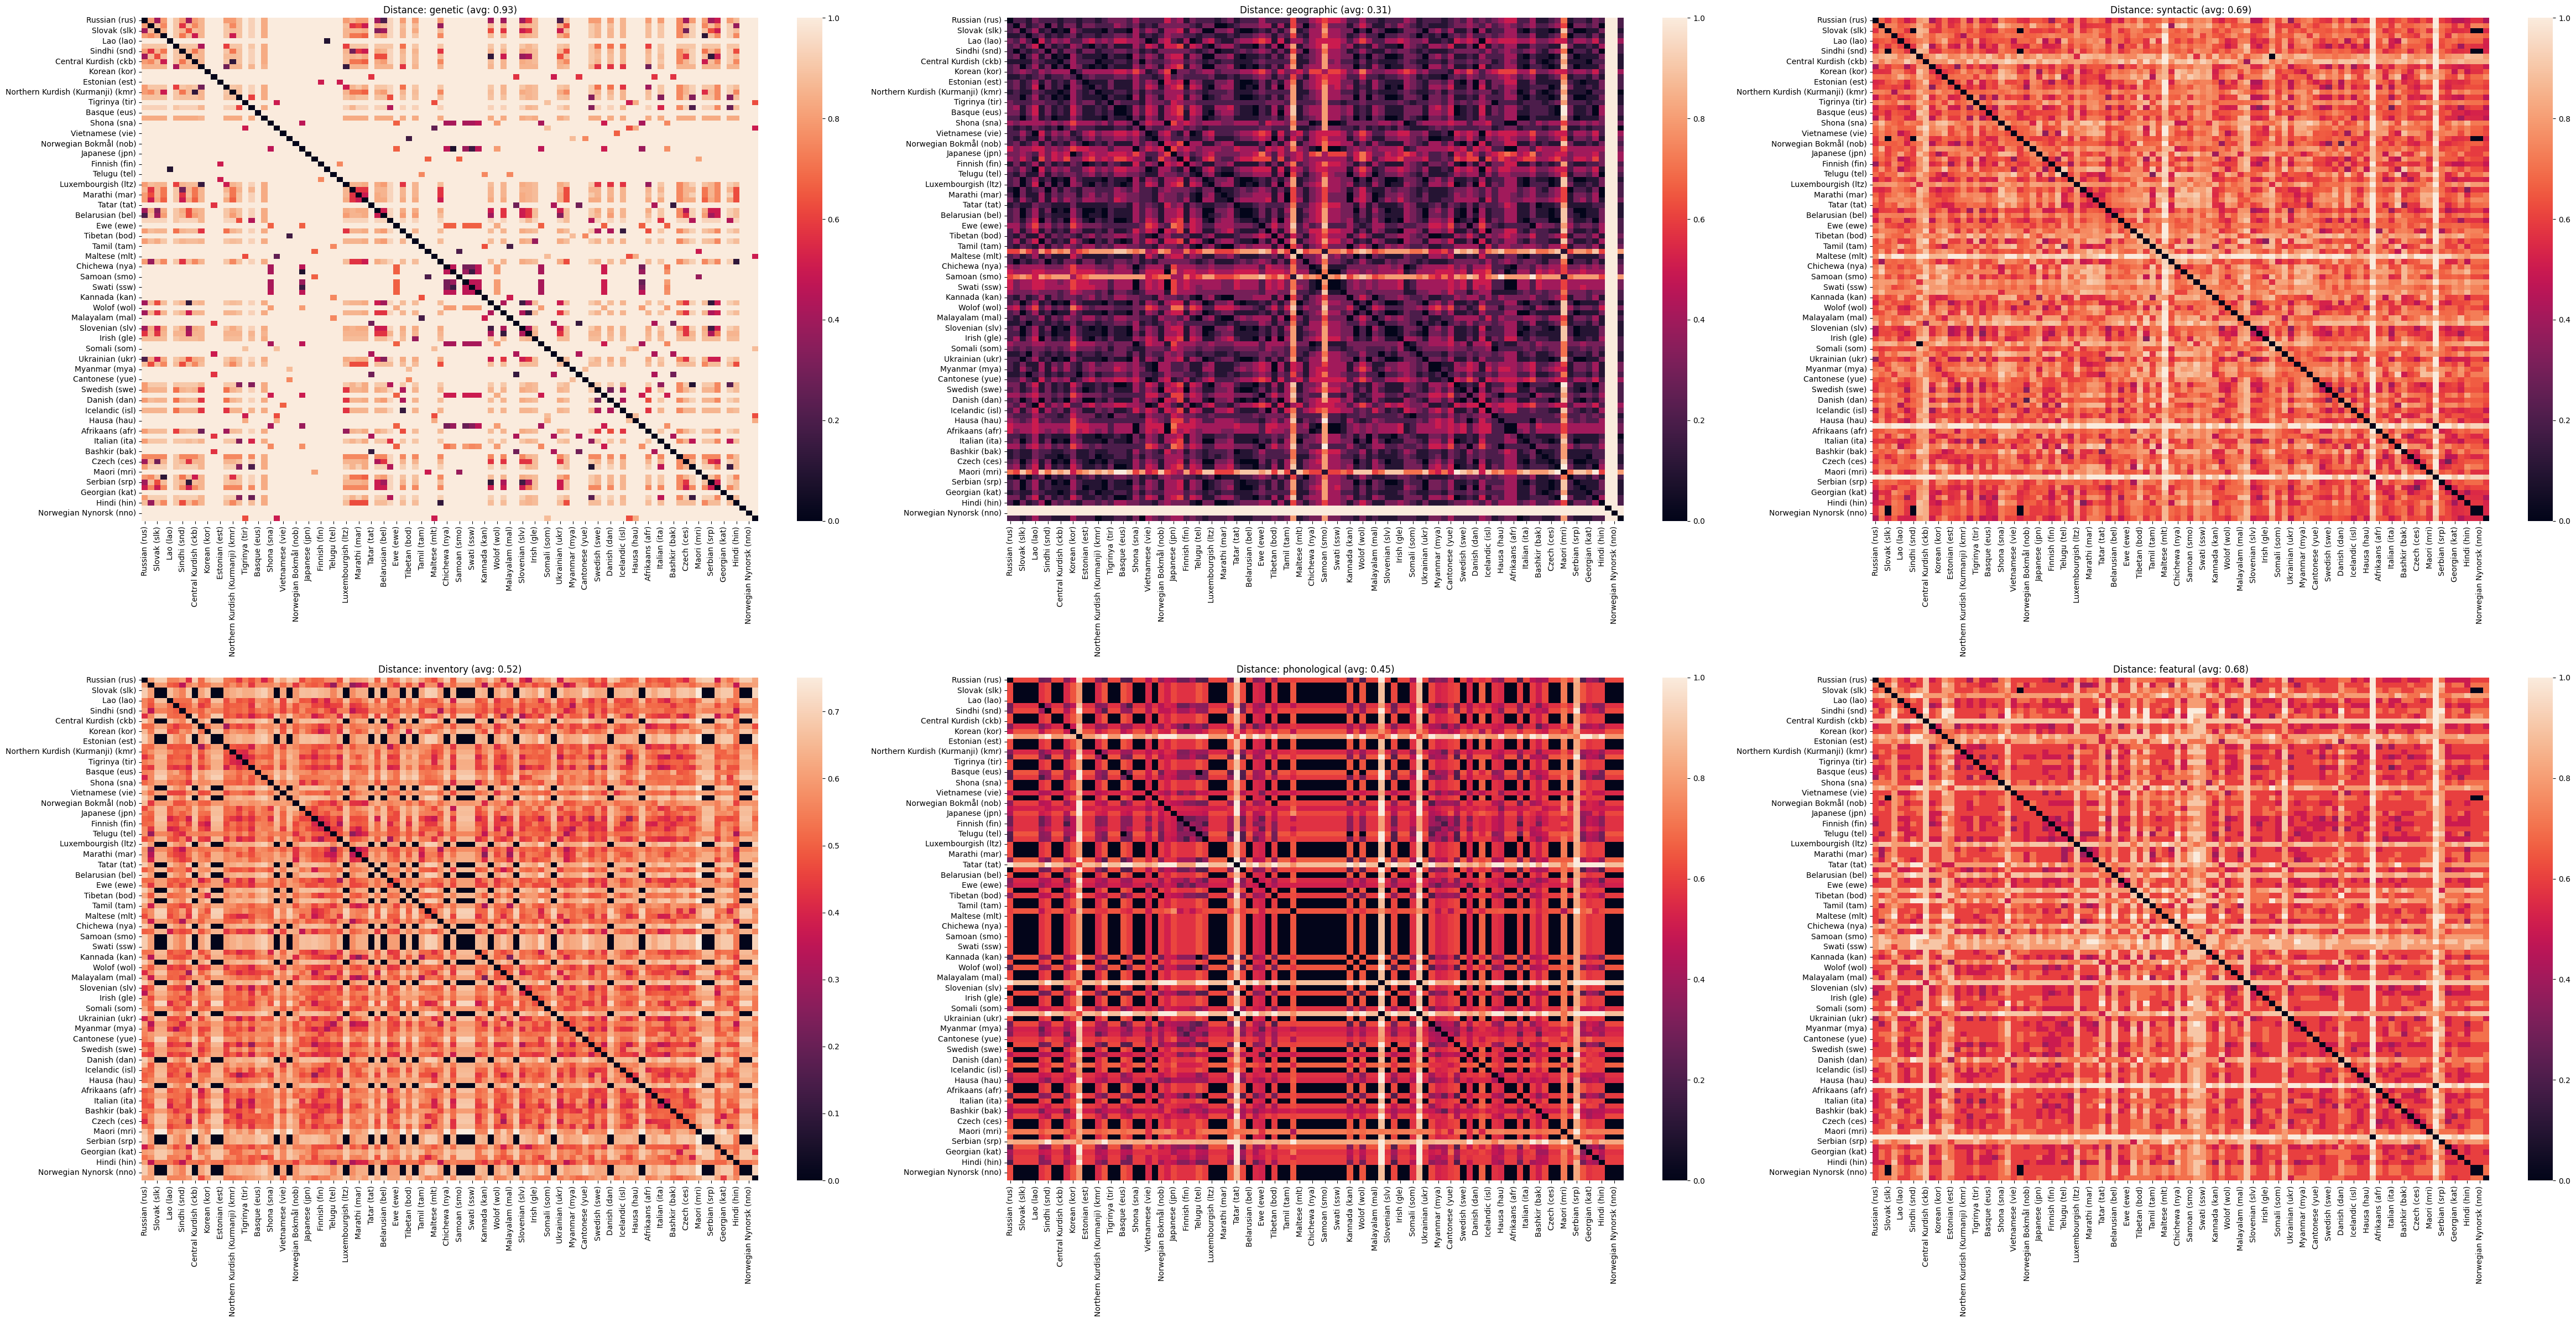

In [61]:
plot_heatmaps_all_distances(True)

In [62]:
def get_best_worst_langs(distance_matrix, language, N=5, make_human_readable=False):
    distances = distance_matrix[language]
    distances = distances.drop(index=language).sort_values()
    best, worst = distances.head(N), distances.tail(N)
    if make_human_readable:
        worst.index = [f"{lang_to_human_readable_language[l]} ({l})" for l in worst.index]
        best.index = [f"{lang_to_human_readable_language[l]} ({l})" for l in best.index]

    return {"chosen": f"{lang_to_human_readable_language[language]} ({language})" if make_human_readable else lang, "best": best.to_dict(), "worst": worst.to_dict()}

In [63]:
pprint(get_best_worst_langs(get_distance_matrix("phonological"), 'swe', make_human_readable=True, N=10))

{
│   'chosen': 'Swedish (swe)',
│   'best': {
│   │   'Chichewa (nya)': 0.0002,
│   │   'Marathi (mar)': 0.0002,
│   │   'Belarusian (bel)': 0.0002,
│   │   'Faroese (fao)': 0.0002,
│   │   'Welsh (cym)': 0.0002,
│   │   'Tamil (tam)': 0.0002,
│   │   'Maltese (mlt)': 0.0002,
│   │   'Urdu (urd)': 0.0002,
│   │   'Norwegian Nynorsk (nno)': 0.0002,
│   │   'Xhosa (xho)': 0.0002
│   },
│   'worst': {
│   │   'Wolof (wol)': 0.641,
│   │   'Telugu (tel)': 0.641,
│   │   'Khmer (khm)': 0.6667,
│   │   'Sinhala (sin)': 0.6667,
│   │   'Maori (mri)': 0.7223,
│   │   'Uighur (uig)': 0.7877,
│   │   'Serbian (srp)': 0.8278,
│   │   'Kazakh (kaz)': 0.879,
│   │   'Turkmen (tuk)': 0.879,
│   │   'Tatar (tat)': 0.879
│   }
}

## Transfer learning experiments

### Tasks

#### Sentence tasks
- Language ID
- Orthography ID

#### Sentence pair tasks
- "Do these sentences have the same meaning?"
- "Do these sentences have the same orthography?"
- "Do these sentences have the same language?"

- XNLI (machine translated training data -> **bad**)

### Experimental conditions
- Which languages to pick to pretrain (up to K of L)
- Mix NTREX & FLORES vs not?
    - Sampling would need to happen at the *sentence ID* level
- Which model to use?

### What is the question we're trying to ask?

- For each evaluation language $l_{\text{eval}}$, how beneficial is it to have $l_{\text{finetune}}$ present in finetuning?
- How does this change given that some other languages are already present?
- Is is possible to "intelligently" pick transfer resources?
    - Formulated as maximizing some **expected utility**?

# Crucial prelim questions

1. How many languages are needed to get good performance on task?
2. How well do each of the tasks work?
3. How long does it take to train this?
4. Is SLURMification necessary?

In [64]:
cuda_report()

GPUs available? True
Number of GPUs: 2


### Multilingual BERT @ orthography classification task

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

In [66]:
def compute_metrics(eval_pred, id_to_label):
    
    f1 = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    metrics = {
        "macro_f1": f1.compute(
            predictions=predictions, references=labels, average="macro"
        )["f1"],
        "micro_f1": f1.compute(
            predictions=predictions, references=labels, average="micro"
        )["f1"],
    }

    # Per-class F1s
    class_f1s = f1.compute(
        predictions=predictions, references=labels, average=None
    )["f1"]
    
    class_ids = sorted(set(predictions) | set(labels))
    f1s_per_class = {
        id_to_label[class_id]: f1_score
        for class_id, f1_score in zip(class_ids, class_f1s)
    }
    metrics.update({f"f1_{id_to_label[class_id]}": f1_score
                    for class_id, f1_score in zip(class_ids, class_f1s)})

    # Confusion matrix
    labels_human_readable = [id_to_label[i] for i in labels]
    predictions_human_readable = [id_to_label[i] for i in predictions]

    _labels_set = set()
    for hum_readable in labels_human_readable, predictions_human_readable:
        _labels_set.update(hum_readable)

    _labels = sorted(_labels_set)

    remove_zero_rows = lambda df: df.loc[~(df==0).all(axis=1)]
    remove_zero_cols = lambda df: df.loc[:, (df != 0).any(axis=0)]

    cm = sk_confusion_matrix(
        y_true=labels_human_readable,
        y_pred=predictions_human_readable,
        labels=_labels,
    )
    confusion_df = pd.DataFrame(cm)
    confusion_df.columns = _labels
    confusion_df.index = _labels
#     confusion_df = remove_zero_rows(confusion_df)
#     confusion_df = remove_zero_cols(confusion_df)

    print("\n\n")
    pprint(confusion_df)
    print("\n\n")
    
    metrics['confusion_matrix'] = confusion_df

    return metrics

## Let's train our model!

#### Training arguments:

In [67]:
orth_clf_output_dir="./orth_clf_results"
batch_size=180
save_total_limit=1
learning_rate=5e-5
save_steps=-1
eval_steps=-1
warmup_steps=0
logging_steps=0
num_train_epochs=None
max_steps=20

In [68]:
def experiment(
    flores_path,
    ntrex_path,
    model_name,
    label_column,
    text_column,
    finetune_langs,
    test_langs,
    max_length_tokens,
    output_dir,
    batch_size,
    learning_rate,
    max_steps,
    compute_metrics,
    label_to_id=None,
    save_total_limit=1,
    save_steps=0,
    eval_steps=0,
    warmup_steps=0,
    logging_steps=0,
    num_train_epochs=None,
    data_loading_functions=None,
    
):
    if not data_loading_functions:
        data_loading_functions = [add_orthography_column, rename_to_label]
    
    _load_data_for_text_clf = ft.partial(
        load_data_for_text_clf,
        flores_path=flores_path,
        ntrex_path=ntrex_path,
        model_name=model_name,
        label_column=label_column,
        text_column=text_column,
        finetune_langs=finetune_langs,
        test_langs=test_langs,
        max_length_tokens=max_length_tokens
    )
    
    data_ft, data_test, flores, ntrex, language_to_id, id_to_language = \
    _load_data_for_text_clf(
        intermediate_functions=data_loading_functions
    )
    
    if not label_to_id:
        id_to_label = dict(enumerate(sorted(set(data_ft['label']) | set(data_test['label']))))
    
    label_to_id = invert_dict(id_to_label)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    clf_preprocess_function = ft.partial(
        single_sentence_preprocess_function, 
        label_to_id=label_to_id, 
        tokenizer=tokenizer, 
        max_length_tokens=max_length_tokens
    )

    data_ft = data_ft.map(clf_preprocess_function, batched=True)
    data_test = data_test.map(clf_preprocess_function, batched=True)
    
    label_set = set(data_ft['label']) | set(data_test['label'])

    # Load the XLM-R tokenizer and model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_set)
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=save_total_limit,
        learning_rate=learning_rate,
        save_steps=save_steps,
        eval_steps=eval_steps,
        evaluation_strategy="no"
        if eval_steps < 0
        else {0: "epoch"}.get(eval_steps, "steps"),
        warmup_steps=warmup_steps,
        logging_steps=logging_steps,
        logging_strategy="no"
        if logging_steps < 0
        else {0: "epoch"}.get(logging_steps, "steps"),
        overwrite_output_dir=True,
        num_train_epochs=num_train_epochs,
        max_steps=max_steps,

    )
    
    pprint(training_args)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    compute_metrics = ft.partial(
        compute_metrics,
        id_to_label=id_to_label
    )
    
    # Define the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data_ft,
        eval_dataset=data_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        
    )
    metrics_before_train = trainer.evaluate()
    try:
        trainer.train(resume_from_checkpoint=True)
    except ValueError:
        trainer.train()
    metrics_after_train = trainer.evaluate()
    
    return trainer, metrics_before_train, metrics_after_train

In [69]:
MBERT = "bert-base-multilingual-cased"
text = "text"
orthography = 'orthography'

orth_clf_output_dir="./orth_clf_results"
batch_size=160
save_total_limit=4
learning_rate=5e-5
save_steps=400
eval_steps=-1
warmup_steps=0
logging_steps=0
num_train_epochs=1
max_steps=0

rename_orth_to_label = ft.partial(_rename_text_and_label_col,
                                  text_column=text, 
                                  label_column=orthography)

In [70]:
orth_clf_experiment = ft.partial(
    experiment,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
    model_name=MBERT,
    label_column=orthography,
    text_column=text,
    max_length_tokens=MAX_LENGTH_TOKENS,
    output_dir=orth_clf_output_dir,
    batch_size=batch_size,
    learning_rate=learning_rate,
    max_steps=max_steps,
    save_total_limit=1,
    save_steps=save_steps,
    eval_steps=eval_steps,
    warmup_steps=warmup_steps,
    logging_steps=logging_steps,
    num_train_epochs=num_train_epochs,
    data_loading_functions=[add_orthography_column, rename_orth_to_label],
    test_langs=None,
    compute_metrics=compute_metrics
)

In [71]:
# exp_results = orth_clf_experiment(finetune_langs="flores")

In [72]:
def plot_confusion_matrix(confusion_matrix, title, figsize=(15,15), should_normalize=False, normalize_this="rows"):
    
    if should_normalize:
        normalizer = confusion_matrix.sum(axis=({"rows": 0, "columns": 1}[normalize_this]))
        confusion_matrix = confusion_matrix / normalizer
        confusion_matrix = confusion_matrix.round(2).fillna(0)
    confusion_matrix_display = ConfusionMatrixDisplay(
        confusion_matrix.to_numpy(), 
        display_labels=confusion_matrix.columns
    )
    cm_fig, cm_ax = plt.subplots(figsize=figsize)
    cm_plot  =confusion_matrix_display.plot(ax=cm_ax)
    plt.tight_layout()
    plt.title(title)
    

In [73]:
# plot_confusion_matrix(exp_results[1]['eval_confusion_matrix'], should_normalize=True,
#                       title="Zero-shot orthography classification performance")

In [74]:
# plot_confusion_matrix(exp_results[-1]['eval_confusion_matrix'], should_normalize=True,
#                       title="Performance after single epoch")

In [75]:
%%bash
rm -vrf orth_clf_results/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [76]:
# exp_results_few = orth_clf_experiment(finetune_langs=["fin"])

In [77]:
# cm_few_before = exp_results_few[1]['eval_confusion_matrix']
# cm_few_after = exp_results_few[-1]['eval_confusion_matrix']

In [78]:
# plot_confusion_matrix(cm_few_before, should_normalize=True,
#                       title="Zero-shot performance")

What about training on just a few

In [79]:
# plot_confusion_matrix(cm_few_after, should_normalize=True,
#                       title="Performance after single epoch")

# Sentence pair classification

In [80]:
lang_pairs

['eng-fin']

In [81]:
def create_pairs_data(dataset, lang_pairs, n_pos, n_neg, num_rows):

    indices = [ix for ix in range(num_rows)]
    if n_pos > 0:
        positive_indices = np.random.randint(low=0, high=num_rows, size=n_pos)
    else:
        positive_indices = indices
        n_pos = len(indices)
    
    potential_negative_pairs = [
        (a, b) for a, b in it.combinations(indices, 2) if a != b
    ]
    
    if n_neg < 0:
        n_neg = n_pos
    
    if n_neg > 0:
        negative_indices = np.random.choice(
            range(len(potential_negative_pairs)), size=n_neg
        )
    else:
        negative_indices = list(range(len(potential_negative_pairs)))
        
        
    negative_indices = [potential_negative_pairs[idx] for idx in negative_indices]
    negative_as = [a for (a,b) in negative_indices]
    negative_bs = [b for (a,b) in negative_indices]
    
    N_lang_pairs = len(lang_pairs)
    positive_examples = []
    negative_examples = []
    for ix, pair in enumerate(lang_pairs, start=1):
        print(f"pair {ix}/{N_lang_pairs}: {pair}")
        lang1, lang2 = pair.split("-")

        lang1_pos = dataset[lang1][positive_indices]["text"]
        lang2_pos = dataset[lang2][positive_indices]["text"]
        lang1_neg = dataset[lang1][negative_as]["text"]
        lang2_neg = dataset[lang2][negative_bs]["text"]
        
        _positive_examples = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": s1,
                "sentence2": s2,
                "label": "yes",
            }

            for s1, s2 in zip(lang1_pos, lang2_pos)
        ]
        positive_examples.extend(_positive_examples)

        
        _negative_examples = [
            {
                "language1": lang1,
                "language2": lang2,
                "sentence1": s1,
                "sentence2": s2,
                "label": "no",
            }

            for s1, s2 in zip(lang1_neg, lang2_neg)
        ]
        negative_examples.extend(_negative_examples)

    sentence_pairs = ds.Dataset.from_pandas(
        pd.DataFrame.from_records(positive_examples + negative_examples)
    )

    return sentence_pairs

In [82]:
all_available_lang_pairs = [f"{a}-{b}" for a,b in it.product(language_to_id, language_to_id) if a != b]

In [83]:
len(all_available_lang_pairs)

9506

In [84]:
# _ = create_pairs_data(ntrex, all_available_lang_pairs, -1, -1, num_rows=ntrex["eng"].num_rows)

In [85]:
def load_data_for_sentence_pair_clf(
    flores_path,
    ntrex_path,
    lang_pairs,
    n_pos, n_neg,
    intermediate_functions=None
):
    if intermediate_functions is None:
        intermediate_functions = []
        
    # STEP 1: LOAD RAW DATA & CREATE MAPPINGS
    flores, ntrex, language_to_id, id_to_language = load_flores_ntrex(
        flores_path, ntrex_path
    )

    # STEP 2: CREATE PAIRS
    data_for_finetune = create_pairs_data(ntrex, lang_pairs, n_pos, n_neg, num_rows=ntrex["eng"].num_rows)
    data_for_test = create_pairs_data(flores, lang_pairs, n_pos, n_neg, num_rows=flores["eng"].num_rows)
    
    # STEP 3: APPLY OPTIONAL INTERMEDIATE FUNCTIONS
    for func in intermediate_functions:
        try:
            print(f"Executing intermediate func: {func.__name__}")
        except:
            print(f"Executing intermediate func: {func.func.__name__}")
        data_for_finetune = func(data_for_finetune)
        data_for_test = func(data_for_test)

    return (
        data_for_finetune,
        data_for_test,
        flores,
        ntrex,
        language_to_id,
        id_to_language,
    )

_load_data_for_sentence_pair_clf = ft.partial(
    load_data_for_sentence_pair_clf,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
)

In [86]:
def sentence_pair_experiment(
    flores_path,
    ntrex_path,
    model_name,
    lang_pairs,
    max_length_tokens,
    output_dir,
    batch_size,
    learning_rate,
    max_steps,
    compute_metrics,
    n_pos=-1, n_neg=-1,
    label_to_id=None,
    save_total_limit=1,
    save_steps=0,
    eval_steps=0,
    warmup_steps=0,
    logging_steps=0,
    num_train_epochs=None,
    data_loading_functions=None,
    verbose=False
    
):
    if not data_loading_functions:
        data_loading_functions = []
    
    _load_data_for_sentence_pair_clf = ft.partial(
        load_data_for_sentence_pair_clf,
        flores_path=flores_path,
        ntrex_path=ntrex_path,
        lang_pairs=lang_pairs,
        n_pos=n_pos, n_neg=n_neg
    )
    
    data_ft, data_test, flores, ntrex, language_to_id, id_to_language = \
    _load_data_for_sentence_pair_clf(
        intermediate_functions=data_loading_functions
    )
    
    if not label_to_id:
        id_to_label = dict(enumerate(sorted(set(data_ft['label']) | set(data_test['label']))))
    
    label_to_id = invert_dict(id_to_label)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    clf_preprocess_function = ft.partial(
        sentence_pair_preprocess_function, 
        label_to_id=label_to_id, 
        tokenizer=tokenizer, 
        max_length_tokens=max_length_tokens
    )

    data_ft = data_ft.map(clf_preprocess_function, batched=True)
    data_test = data_test.map(clf_preprocess_function, batched=True)
    
    label_set = set(data_ft['label']) | set(data_test['label'])

    # Load the tokenizer and model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_set)
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=save_total_limit,
        learning_rate=learning_rate,
        save_steps=save_steps,
        eval_steps=eval_steps,
        evaluation_strategy="no"
        if eval_steps < 0
        else {0: "epoch"}.get(eval_steps, "steps"),
        warmup_steps=warmup_steps,
        logging_steps=logging_steps,
        logging_strategy="no"
        if logging_steps < 0
        else {0: "epoch"}.get(logging_steps, "steps"),
        overwrite_output_dir=True,
        num_train_epochs=num_train_epochs,
        max_steps=max_steps,

    )
    
    if verbose:
        pprint(training_args)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    compute_metrics = ft.partial(
        compute_metrics,
        id_to_label=id_to_label
    )
    
    # Define the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data_ft,
        eval_dataset=data_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        
    )
    metrics_before_train = trainer.evaluate()
    try:
        trainer.train(resume_from_checkpoint=True)
    except ValueError:
        trainer.train()
    metrics_after_train = trainer.evaluate()
    
    return metrics_before_train, metrics_after_train

In [87]:
same_sentence_output_dir = "./same_sentence_results"

In [88]:
def compute_same_sentence_metrics(eval_pred, id_to_label, verbose=True):
    
    f1 = evaluate.load("f1")
    predictions, labels = eval_pred
    
    if verbose:
        print("predictions")
        print(predictions)
    
    predictions = np.argmax(predictions, axis=1)

    metrics = {
        "macro_f1": f1.compute(
            predictions=predictions, references=labels, average="macro"
        )["f1"],
        "micro_f1": f1.compute(
            predictions=predictions, references=labels, average="micro"
        )["f1"],
    }

    # Per-class F1s
    class_f1s = f1.compute(
        predictions=predictions, references=labels, average=None
    )["f1"]
    
    class_ids = sorted(set(predictions) | set(labels))
    f1s_per_class = {
        id_to_label[class_id]: f1_score
        for class_id, f1_score in zip(class_ids, class_f1s)
    }
    metrics.update({f"f1_{id_to_label[class_id]}": f1_score
                    for class_id, f1_score in zip(class_ids, class_f1s)})

    # Confusion matrix
    labels_human_readable = [id_to_label[i] for i in labels]
    predictions_human_readable = [id_to_label[i] for i in predictions]

    _labels_set = set()
    for hum_readable in labels_human_readable, predictions_human_readable:
        _labels_set.update(hum_readable)

    _labels = sorted(_labels_set)

    remove_zero_rows = lambda df: df.loc[~(df==0).all(axis=1)]
    remove_zero_cols = lambda df: df.loc[:, (df != 0).any(axis=0)]

    cm = sk_confusion_matrix(
        y_true=labels_human_readable,
        y_pred=predictions_human_readable,
        labels=_labels,
    )
    confusion_df = pd.DataFrame(cm)
    confusion_df.columns = _labels
    confusion_df.index = _labels

    if verbose:
        print("\n\n")
        pprint(confusion_df)
        print("\n\n")
    
    metrics['confusion_matrix'] = confusion_df

    return metrics

In [89]:
same_sentence_experiment = ft.partial(
    sentence_pair_experiment,
    flores_path=FLORES_PATH,
    ntrex_path=NTREX_PATH,
    model_name=MBERT,
    max_length_tokens=MAX_LENGTH_TOKENS,
    output_dir=same_sentence_output_dir,
    batch_size=batch_size,
    learning_rate=learning_rate,
    max_steps=max_steps,
    save_total_limit=1,
    save_steps=save_steps,
    eval_steps=eval_steps,
    warmup_steps=warmup_steps,
    logging_steps=logging_steps,
    num_train_epochs=3,
    data_loading_functions=None,
    compute_metrics=ft.partial(compute_same_sentence_metrics, verbose=False),
    verbose=False
)

### FInnish sentence pair classification

- Let's do an experiment on `fin-*` sentence pair classification.
- Each pair will be trained and evaluated as a separate experiment.
- At the end we can inspect whether there are any patterns

In [90]:
all_fin_pairs = sorted([p for p in all_available_lang_pairs if p.startswith("fin-")])

In [91]:
len(all_fin_pairs)

97

In [92]:
all_fin_same_sentence_exp_results = {}
for pair in track(all_fin_pairs, description="Classifying pairs..."):
    all_fin_same_sentence_exp_results[pair] = same_sentence_experiment(lang_pairs=[pair])

Output()

pair 1/1: fin-afr

pair 1/1: fin-afr

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.526500
26,0.126200
39,0.057200


pair 1/1: fin-amh

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.641600
26,0.528100
39,0.438000


pair 1/1: fin-arb

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.269700
26,0.124500
39,0.068900


pair 1/1: fin-bak

pair 1/1: fin-bak

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.293300
26,0.115400
39,0.063300


pair 1/1: fin-bel

pair 1/1: fin-bel

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.248800
26,0.086800
39,0.046600


pair 1/1: fin-bem

pair 1/1: fin-bem

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.357900
26,0.169800
39,0.111500


pair 1/1: fin-ben

pair 1/1: fin-ben

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.300500
26,0.116100
39,0.060300


pair 1/1: fin-bod

pair 1/1: fin-bod

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.619600
26,0.469900
39,0.404600


pair 1/1: fin-bos

pair 1/1: fin-bos

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.231900
26,0.072200
39,0.035700


pair 1/1: fin-bul

pair 1/1: fin-bul

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.248200
26,0.086500
39,0.052000


pair 1/1: fin-cat

pair 1/1: fin-cat

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.240000
26,0.085000
39,0.043100


pair 1/1: fin-ces

pair 1/1: fin-ces

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.238800
26,0.073900
39,0.038600


pair 1/1: fin-ckb

pair 1/1: fin-ckb

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.623900
26,0.379000
39,0.282700


pair 1/1: fin-cym

pair 1/1: fin-cym

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.287000
26,0.114600
39,0.073000


pair 1/1: fin-dan

pair 1/1: fin-dan

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.232200
26,0.073600
39,0.041000


pair 1/1: fin-deu

pair 1/1: fin-deu

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.226300
26,0.079300
39,0.039700


pair 1/1: fin-dzo

pair 1/1: fin-dzo

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.677500
26,0.586300
39,0.527000


pair 1/1: fin-ell

pair 1/1: fin-ell

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.265100
26,0.109600
39,0.051800


pair 1/1: fin-eng

pair 1/1: fin-eng

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.231200
26,0.076000
39,0.030600


pair 1/1: fin-est

pair 1/1: fin-est

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.249300
26,0.073700
39,0.035700


pair 1/1: fin-eus

pair 1/1: fin-eus

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.262900
26,0.110100
39,0.058900


pair 1/1: fin-ewe

pair 1/1: fin-ewe

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.388400
26,0.207600
39,0.149800


pair 1/1: fin-fao

pair 1/1: fin-fao

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.283900
26,0.101000
39,0.055800


pair 1/1: fin-fij

pair 1/1: fin-fij

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.565700
26,0.430800
39,0.352900


pair 1/1: fin-fra

pair 1/1: fin-fra

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.252700
26,0.078400
39,0.038900


pair 1/1: fin-gle

pair 1/1: fin-gle

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.335800
26,0.138900
39,0.077400


pair 1/1: fin-glg

pair 1/1: fin-glg

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.236900
26,0.082400
39,0.043400


pair 1/1: fin-guj

pair 1/1: fin-guj

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.338200
26,0.169800
39,0.094100


pair 1/1: fin-hau

pair 1/1: fin-hau

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.387700
26,0.206000
39,0.135700


pair 1/1: fin-heb

pair 1/1: fin-heb

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.255300
26,0.099200
39,0.056400


pair 1/1: fin-hin

pair 1/1: fin-hin

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.281400
26,0.095200
39,0.061100


pair 1/1: fin-hrv

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.242800
26,0.076600
39,0.039000


pair 1/1: fin-hun

pair 1/1: fin-hun

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.247100
26,0.084600
39,0.046900


pair 1/1: fin-hye

pair 1/1: fin-hye

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.280800
26,0.096100
39,0.059900


pair 1/1: fin-ibo

pair 1/1: fin-ibo

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.369600
26,0.189900
39,0.124200


pair 1/1: fin-ind

pair 1/1: fin-ind

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.244600
26,0.079900
39,0.043800


pair 1/1: fin-isl

pair 1/1: fin-isl

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.289400
26,0.099900
39,0.060000


pair 1/1: fin-ita

pair 1/1: fin-ita

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.228000
26,0.072900
39,0.039400


pair 1/1: fin-jpn

pair 1/1: fin-jpn

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.259000
26,0.100900
39,0.062500


pair 1/1: fin-kan

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.327100
26,0.130900
39,0.082400


pair 1/1: fin-kat

pair 1/1: fin-kat

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.296400
26,0.117900
39,0.075900


pair 1/1: fin-kaz

pair 1/1: fin-kaz

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.282100
26,0.101700
39,0.062900


pair 1/1: fin-khm

pair 1/1: fin-khm

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.454400
26,0.300200
39,0.239500


pair 1/1: fin-kin

pair 1/1: fin-kin

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.390700
26,0.198900
39,0.130700


pair 1/1: fin-kir

pair 1/1: fin-kir

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.293300
26,0.106700
39,0.058000


pair 1/1: fin-kmr

pair 1/1: fin-kmr

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.420600
26,0.219000
39,0.152500


pair 1/1: fin-kor

pair 1/1: fin-kor

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.261100
26,0.100700
39,0.053200


pair 1/1: fin-lao

pair 1/1: fin-lao

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.386300
26,0.222500
39,0.162100


pair 1/1: fin-lit

pair 1/1: fin-lit

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.253900
26,0.093400
39,0.056200


pair 1/1: fin-ltz

pair 1/1: fin-ltz

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.274300
26,0.100100
39,0.052200


pair 1/1: fin-mal

pair 1/1: fin-mal

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.341500
26,0.182400
39,0.094200


pair 1/1: fin-mar

pair 1/1: fin-mar

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.314500
26,0.133300
39,0.071900


pair 1/1: fin-mkd

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.259000
26,0.093500
39,0.049800


pair 1/1: fin-mlt

pair 1/1: fin-mlt

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.360300
26,0.153700
39,0.102800


pair 1/1: fin-mri

pair 1/1: fin-mri

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.399800
26,0.213700
39,0.153600


pair 1/1: fin-mya

pair 1/1: fin-mya

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.574500
26,0.377500
39,0.298200


pair 1/1: fin-nld

pair 1/1: fin-nld

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.246500
26,0.086800
39,0.046800


pair 1/1: fin-nno

pair 1/1: fin-nno

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.233400
26,0.075900
39,0.039900


pair 1/1: fin-nob

pair 1/1: fin-nob

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.229300
26,0.073100
39,0.041500


pair 1/1: fin-nso

pair 1/1: fin-nso

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.367600
26,0.183800
39,0.122200


pair 1/1: fin-nya

pair 1/1: fin-nya

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.374400
26,0.174500
39,0.113700


pair 1/1: fin-pan

pair 1/1: fin-pan

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.400500
26,0.153000
39,0.089900


pair 1/1: fin-pol

pair 1/1: fin-pol

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.251100
26,0.080700
39,0.040700


pair 1/1: fin-por

pair 1/1: fin-por

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.237900
26,0.077900
39,0.035700


pair 1/1: fin-prs

pair 1/1: fin-prs

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.266100
26,0.100300
39,0.056800


pair 1/1: fin-ron

pair 1/1: fin-ron

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.240600
26,0.077900
39,0.043400


pair 1/1: fin-rus

pair 1/1: fin-rus

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.239200
26,0.083900
39,0.040600


pair 1/1: fin-sin

pair 1/1: fin-sin

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.616600
26,0.448500
39,0.369800


pair 1/1: fin-slk

pair 1/1: fin-slk

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.246800
26,0.076900
39,0.043100


pair 1/1: fin-slv

pair 1/1: fin-slv

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.256000
26,0.088100
39,0.050200


pair 1/1: fin-smo

pair 1/1: fin-smo

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.385600
26,0.191900
39,0.127100


pair 1/1: fin-sna

pair 1/1: fin-sna

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.412300
26,0.212300
39,0.139800


pair 1/1: fin-snd

pair 1/1: fin-snd

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.534100
26,0.321300
39,0.217500


pair 1/1: fin-som

pair 1/1: fin-som

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.395400
26,0.190000
39,0.129100


pair 1/1: fin-spa

pair 1/1: fin-spa

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.226400
26,0.066500
39,0.030200


pair 1/1: fin-srp

pair 1/1: fin-srp

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.255400
26,0.084600
39,0.047600


pair 1/1: fin-ssw

pair 1/1: fin-ssw

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.382200
26,0.190200
39,0.127400


pair 1/1: fin-swe

pair 1/1: fin-swe

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.237000
26,0.084600
39,0.042500


pair 1/1: fin-tam

pair 1/1: fin-tam

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.309900
26,0.129000
39,0.078200


pair 1/1: fin-tat

pair 1/1: fin-tat

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.292300
26,0.127600
39,0.066700


pair 1/1: fin-tel

pair 1/1: fin-tel

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.334500
26,0.131300
39,0.079100


pair 1/1: fin-tgk

pair 1/1: fin-tgk

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.395600
26,0.259700
39,0.204300


pair 1/1: fin-tha

pair 1/1: fin-tha

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.331600
26,0.153200
39,0.090100


pair 1/1: fin-tir

pair 1/1: fin-tir

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.622900
26,0.461700
39,0.373600


pair 1/1: fin-tsn

pair 1/1: fin-tsn

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.375800
26,0.187500
39,0.126400


pair 1/1: fin-tuk

pair 1/1: fin-tuk

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.367500
26,0.159500
39,0.096200


pair 1/1: fin-tur

pair 1/1: fin-tur

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.273400
26,0.094100
39,0.050900


pair 1/1: fin-uig

pair 1/1: fin-uig

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.622300
26,0.431400
39,0.335700


pair 1/1: fin-ukr

pair 1/1: fin-ukr

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.260500
26,0.091700
39,0.053200


pair 1/1: fin-urd

pair 1/1: fin-urd

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.689800
26,0.639400
39,0.578600


pair 1/1: fin-vie

pair 1/1: fin-vie

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.696100
26,0.664700
39,0.612800


pair 1/1: fin-wol

pair 1/1: fin-wol

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.651200
26,0.576700
39,0.516000


pair 1/1: fin-xho

pair 1/1: fin-xho

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.430900
26,0.222100
39,0.159300


pair 1/1: fin-yor

pair 1/1: fin-yor

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.388800
26,0.212300
39,0.143500


pair 1/1: fin-yue

pair 1/1: fin-yue

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.268900
26,0.088900
39,0.059300


pair 1/1: fin-zho

pair 1/1: fin-zho

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.252500
26,0.083600
39,0.058900


pair 1/1: fin-zul

pair 1/1: fin-zul

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/transformers/optimization.py:391: 
FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch 
implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

/home/jonne/miniconda3/envs/ling-mt-transfer/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: 
UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and 
return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '

Step,Training Loss
13,0.584500
26,0.454900
39,0.380100


In [118]:
fin_same_sent_results_before = {pair: a for pair, (a,b) in all_fin_same_sentence_exp_results.items()}

In [119]:
fin_same_sent_results_after = {pair: b for pair, (a,b) in all_fin_same_sentence_exp_results.items()}

In [120]:
false_positives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['no', 'yes'] 
    for pair in fin_same_sent_results_after
]

false_negatives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['yes', 'no'] 
    for pair in fin_same_sent_results_after
]

true_positives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['yes', 'yes'] 
    for pair in fin_same_sent_results_after
]

true_negatives_after = [
    fin_same_sent_results_after[pair]['eval_confusion_matrix'].loc['no', 'no'] 
    for pair in fin_same_sent_results_after
]

In [121]:
false_positives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['no', 'yes'] 
    for pair in fin_same_sent_results_before
]

false_negatives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['yes', 'no'] 
    for pair in fin_same_sent_results_before
]

true_positives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['yes', 'yes'] 
    for pair in fin_same_sent_results_before
]

true_negatives_before = [
    fin_same_sent_results_before[pair]['eval_confusion_matrix'].loc['no', 'no'] 
    for pair in fin_same_sent_results_before
]

In [122]:
metric_df_after = pd.DataFrame({
    "language_pair": [pair for pair in fin_same_sent_results_after],
    "false_positives": false_positives_after,
    "false_negatives": false_negatives_after,
    'true_positives': true_positives_after,
    'true_negatives': true_negatives_after
})

metric_df_after['total_correct'] = metric_df_after.true_positives + metric_df_after.true_negatives
metric_df_after['total_incorrect'] = metric_df_after.false_positives + metric_df_after.false_negatives

In [123]:
metric_df_before = pd.DataFrame({
    "language_pair": [pair for pair in fin_same_sent_results_before],
    "false_positives": false_positives_before,
    "false_negatives": false_negatives_before,
    'true_positives': true_positives_before,
    'true_negatives': true_negatives_before
})

metric_df_before['total_correct'] = metric_df_before.true_positives + metric_df_before.true_negatives
metric_df_before['total_incorrect'] = metric_df_before.false_positives + metric_df_before.false_negatives

In [124]:
pairs_hum = []
for pair in metric_df_before.language_pair:
    lang_a, lang_b = pair.split("-")
    lang_a_hum = lang_to_human_readable_language[lang_a]
    lang_b_hum = lang_to_human_readable_language[lang_b]
    pair_hum = f"{lang_a_hum} - {lang_b_hum}"
    pairs_hum.append(pair_hum)

In [125]:
metric_df_before['language_pair_hum'] = pairs_hum

In [126]:
pairs_hum = []
for pair in metric_df_after.language_pair:
    lang_a, lang_b = pair.split("-")
    lang_a_hum = lang_to_human_readable_language[lang_a]
    lang_b_hum = lang_to_human_readable_language[lang_b]
    pair_hum = f"{lang_a_hum} - {lang_b_hum}"
    pairs_hum.append(pair_hum)

In [127]:
metric_df_after['language_pair_hum'] = pairs_hum

In [130]:
metric_df_before_after = pd.merge(
    left=metric_df_before[['language_pair', 'total_incorrect']],
    right=metric_df_after[['language_pair', 'total_incorrect']],
    left_on="language_pair", right_on="language_pair",
    suffixes=["_before", "_after"]
)

In [155]:
metric_df_before_after.sort_values('total_incorrect_before', ascending=False)

,language_pair,total_incorrect_before,total_incorrect_after,ratio,language_pair_hum
0,fin-afr,1824,74,0.040570,Finnish - Afrikaans
16,fin-dzo,995,854,0.858291,Finnish - Dzongkha
7,fin-bod,988,669,0.677126,Finnish - Tibetan
12,fin-ckb,977,405,0.414534,Finnish - Central Kurdish
83,fin-tir,975,525,0.538462,Finnish - Tigrinya
...,...,...,...,...,...
74,fin-spa,124,24,0.193548,Finnish - Spanish
62,fin-pol,123,24,0.195122,Finnish - Polish
19,fin-est,101,15,0.148515,Finnish - Estonian
18,fin-eng,95,13,0.136842,Finnish - English


Text(0.5, 1.0, 'Same sentence detection performance')

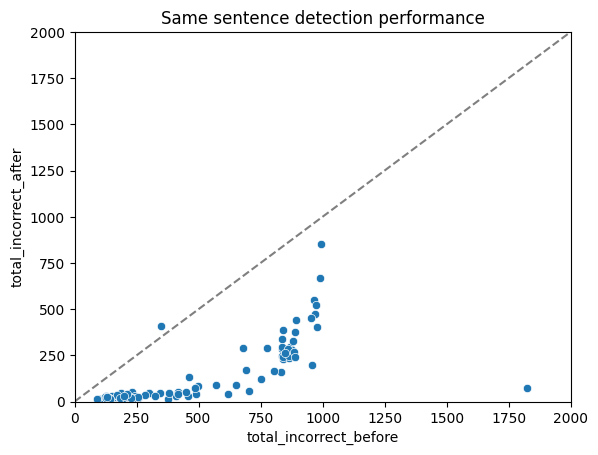

In [154]:
g = sns.scatterplot(
    data=metric_df_before_after, 
    x='total_incorrect_before', 
    y='total_incorrect_after'
)


g.set_xlim(0, 2000)
g.set_ylim(0, 2000)
g.axline([0,0], [1,1], ls='--', c='k', alpha=0.5)
g.set_title("Same sentence detection performance")

In [132]:
def incorrect(df):
    arr = np.array(df)
    total = np.sum(arr, axis=None)
    trace = np.trace(arr)
    return total - trace

In [133]:
incorrect(fin_same_sent_results_before['fin-est']['eval_confusion_matrix'])

101

In [134]:
metric_df_before_after['ratio'] = (metric_df_before_after.total_incorrect_after 
 / metric_df_before_after.total_incorrect_before)

In [135]:
pairs_hum = []
for pair in metric_df_before_after.language_pair:
    lang_a, lang_b = pair.split("-")
    lang_a_hum = lang_to_human_readable_language[lang_a]
    lang_b_hum = lang_to_human_readable_language[lang_b]
    pair_hum = f"{lang_a_hum} - {lang_b_hum}"
    pairs_hum.append(pair_hum)
    
metric_df_before_after['language_pair_hum'] = pairs_hum

<Axes: ylabel='language_pair_hum'>

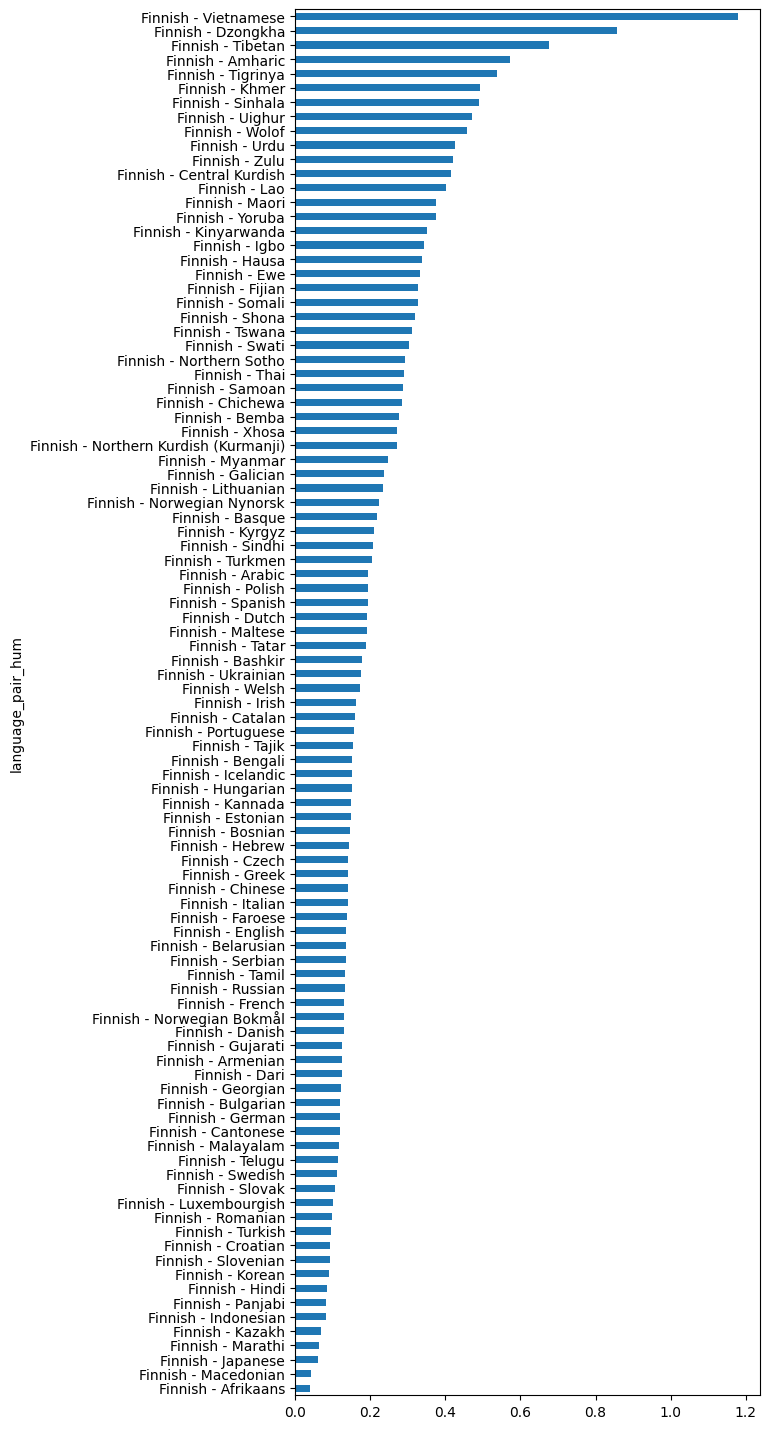

In [136]:
metric_df_before_after.set_index('language_pair_hum')['ratio'].sort_values().plot.barh(figsize=(6, 18))

In [156]:
# class FrozenHuggingFaceModel:
    
#     def __init__(self, model, tokenizer):
#         self.model = model
#         self.tokenizer = tokenizer
#         for param in self.model.parameters():
#             param.requires_grad = False

#     def __call__(self, text):
#         input_ids = torch.tensor(
#             self.tokenizer.encode(text, add_special_tokens=True)
#         ).unsqueeze(0)
#         tokens = [self.tokenizer.convert_ids_to_tokens(ix) for ix in input_ids][0]
#         out = self.model(input_ids, output_hidden_states=True)
#         last_hidden = out.hidden_states[-1]
#         return  input_ids, tokens, last_hidden.squeeze(), out

In [157]:
# mbert_tokenizer = AutoTokenizer.from_pretrained(MBERT)
# mbert_model = AutoModelForSequenceClassification.from_pretrained(MBERT)

In [158]:
# frozen_mbert = FrozenHuggingFaceModel(mbert_model, mbert_tokenizer)

In [159]:
# natalie_input_ids, natalie_tokens, natalie_feats, natalie_out = frozen_mbert("hello this is natalie")

In [160]:
# np.random.seed(12345)
# a = np.random.choice(['yes', 'no'], size=5)
# np.random.seed(12345)
# b = np.random.choice(['yes', 'no'], size=5)

# a == b